**参考资料：**
* [长短期记忆（LSTM）、门控循环单元（GRU）](https://binaryai.blog.csdn.net/article/details/124458163)

**LSTM单元架构：**

![LSTM](./Pictures/LSTM.jpg "model")

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt
import matplotlib

In [2]:
torch.manual_seed(1)
np.random.seed(1)
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Pytorch torch.nn.LSTM
![LSTM](./Pictures/LSTM_model.jpg "model")

**相关公式：**
$$f_t=σ(W_{fx}X_t + b_{fx} + W_{fh}h_{t-1} + b_{fh})$$
$$i_t=σ(W_{ix}X_t + b_{ix} + W_{ih}h_{t-1} + b_{ih})$$
$$o_t=σ(W_{ox}X_t + b_{ox} + W_{oh}h_{t-1} + b_{oh})$$
$$g_t=tanh(W_{gx}X_t + b_{gx} + W_{gh}h_{t-1} + b_{gh})$$
$$c_t=f_t⊙c_{t-1} + i_t⊙g_t$$
$$h_t=o_t⊙tanh(c_t)$$

其中，$f_t$表示遗忘门，$i_t$表示输入门，$o_t$表示输出门，$g_t$表示门控，$c_t$表示记忆状态（cell state），$h_t$表示隐藏状态

**初始化相关参数：**
|参数|描述|
|:---:|:---:| 
|input_size|The number of expected features in the input x|
|hidden_size|The number of features in the hidden state h|
|num_layers|Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1|
|bias|If False, then the layer does not use bias weights b_ih and b_hh. Default: True|
|batch_first|If True, then the input and output tensors are provided as (batch, seq, feature). Default: False|
|dropout|If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0|
|bidirectional|If True, becomes a bidirectional LSTM. Default: False|


**输入参数：**
|参数|描述|
|:---:|:---:| 
|input|shape(seq_len,batch,input_size)|
|$h_0$|shape(num_layers*num_directions,batch,hidden_size)|	
|$c_0$|shape (num_layers * num_directions, batch, hidden_size)|

If ($h_0$, $c_0$) is not provided, both $h_0$ and $c_0$ default to zero.



**输出参数：**
|参数|描述|
|:---:|:---:| 
|output| shape (seq_len, batch, num_directions * hidden_size)|
|$h_n$|shape (num_layers * num_directions, batch, hidden_size)|
|$c_n$|shape (num_layers * num_directions, batch, hidden_size)|


In [3]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, h0, c0):
        # x: [batch_size, seq_len, input_size]
        # h0: [num_layers, batch_size, hidden_size]
        # c0: [num_layers, batch_size, hidden_size]
        outputs, (hn, cn) = self.rnn(inputs, (h0, c0))
        # out: [batch_size, seq_len, hidden_size]
        # hn: [num_layers, batch_size, hidden_size]
        # cn: [num_layers, batch_size, hidden_size]

        # [batch, seq_len, hidden_size] => [batch * seq_len, hidden_size]
        outputs = outputs.view(-1, self.hidden_size)

        # [batch_size * seq_len, hidden_size] => [batch_size * seq_len, output_size]
        outputs = self.linear(outputs)

        # [batch_size * seq_len, output_size] => [batch_size, seq_len, output_size]
        outputs = outputs.view(inputs.size())

        return outputs, hn,cn

In [4]:
def test(model, seq_len, h0, c0):
    input = torch.tensor(0, dtype=torch.float)
    predictions = []
    for _ in range(seq_len):
        input = input.view(1, 1, 1)
        prediction, hn, cn= model(input, h0, c0)
        input = prediction
        h0 = hn
        c0 = cn
        predictions.append(prediction.detach().numpy().ravel()[0])
    # 画图
    time_steps = np.linspace(0, 10, seq_len)
    data = np.sin(time_steps)
    a, = plt.plot(time_steps, data, color='b')
    b = plt.scatter(time_steps[0], 0, color='black', s=10)
    c = plt.scatter(time_steps[1:], predictions[1:], color='red', s=10)
    plt.legend([a, b, c], ['正弦波', '输入', '预测'])
    plt.show()


In [5]:
seq_len = 100 # 序列长度
input_size = 1 # 输入序列特征数
hidden_size = 16 # 隐藏单元特征数
output_size = 1 # 输出特征数
num_layers = 1 # RNN层数
lr = 0.01  # 学习率

model = RNN_LSTM(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss() # 均方差损失
optimizer = optim.Adam(model.parameters(), lr)

h0 = torch.zeros(num_layers, input_size, hidden_size)
c0 = torch.zeros(num_layers, input_size, hidden_size)

In [9]:
def train():
    for i in range(2000):
        # 训练的数据:batch_size=1
        time_steps = np.linspace(0, 10, seq_len + 1)
        data = np.sin(time_steps)
        data = data.reshape(seq_len + 1, 1)
        # 去掉最后一个元素，作为输入
        inputs = torch.tensor(data[:-1]).float().view(1, seq_len, 1)
        # 去掉第一个元素，作为目标值 [batch_size, seq_len, input_size]
        target = torch.tensor(data[1:]).float().view(1, seq_len, 1)

        output, hn,cn = model(inputs, h0, c0)

        # # 与上一个批次的计算图分离 https://www.cnblogs.com/catnofishing/p/13287322.html
        # hn.detach()

        loss = loss_function(output, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        iter = i + 1
        if iter % 100 == 0:
            print("迭代次数: {} loss {}".format(iter, loss.item()))



In [10]:
train()

迭代次数: 100 loss 3.582687668313156e-06
迭代次数: 200 loss 2.1770697458123323e-06
迭代次数: 300 loss 0.00013648711319547147
迭代次数: 400 loss 1.3630534567710129e-06
迭代次数: 500 loss 8.870438819030824e-07
迭代次数: 600 loss 9.060788102033257e-07
迭代次数: 700 loss 9.986580380427768e-07
迭代次数: 800 loss 5.519586352420447e-07
迭代次数: 900 loss 4.321880737734318e-07
迭代次数: 1000 loss 7.403320341836661e-05
迭代次数: 1100 loss 4.7146460246949573e-07
迭代次数: 1200 loss 3.3331366466882173e-07
迭代次数: 1300 loss 2.84227127167469e-07
迭代次数: 1400 loss 0.00010679844854166731
迭代次数: 1500 loss 3.4375355539850716e-07
迭代次数: 1600 loss 2.5405699943803484e-07
迭代次数: 1700 loss 2.22937345029095e-07
迭代次数: 1800 loss 2.0412628032318025e-07
迭代次数: 1900 loss 6.677930741716409e-07
迭代次数: 2000 loss 2.1203217670517915e-07


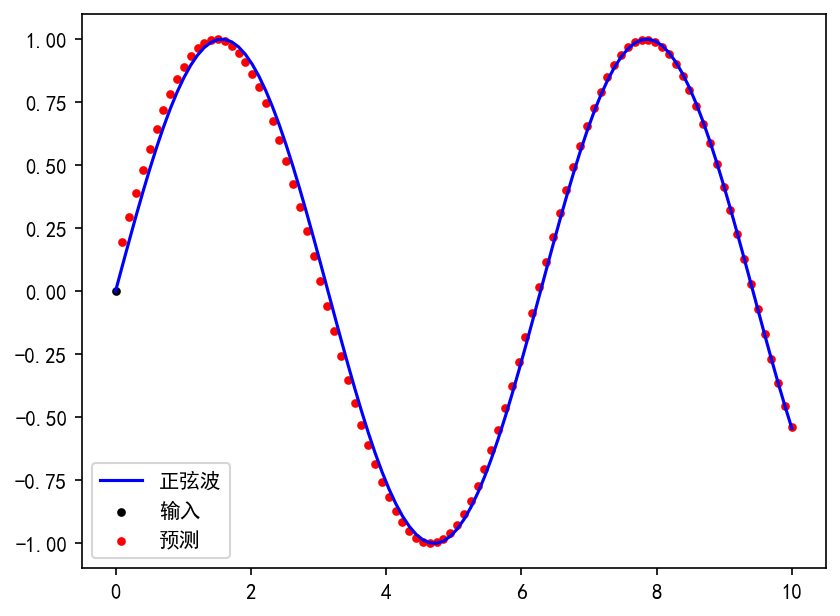

In [11]:
test(model, seq_len, h0, c0)